In [1]:
import pandas as pd
import geopandas as gpd

In [2]:
# Leer las comunas de la Región Metropolitana desde un archivo shapefile y dejar en crs epsg:4326
comunas = gpd.read_file('data\Comunas\comunas.shp').to_crs(epsg=4326)


In [3]:
# Guardar la comuna Maipu en un archivo shapefile solo con su geometría
maipu = comunas[comunas['Comuna'] == 'Maipú'].reset_index(drop=True)
maipu = maipu['geometry']
# Pasar a geodataframe maipu
maipu = gpd.GeoDataFrame(geometry=maipu)


In [4]:
# Leer ISMT de data\ISMT\ISMT_ZC_all_v3_average.shp
ismt = gpd.read_file('data\ISMT\ISMT_ZC_all_v3_average.shp').to_crs(epsg=4326)
# Filtrar por la comuna de Maipu
ismt_maipu = ismt[ismt['nom_cmn'] == 'MAIPÚ'].reset_index(drop=True)
# Me quedo solo con 'prom_ismt', 'AVE_GSE', geocode
ismt_maipu = ismt_maipu[['prom_ismt', 'AVE_GSE', 'geocode']]
ismt_maipu.head(1)


,prom_ismt,AVE_GSE,geocode
0,0.835958,C3,13119201006


In [5]:
# leer data\ZONA_C17\ZONA_C17.shp
zona_c17 = gpd.read_file('data\ZONA_C17\ZONA_C17.shp').to_crs(epsg=4326)
zonas_maipu = zona_c17.loc[zona_c17['NOM_COMUNA']=='MAIPÚ'].reset_index(drop=True) 
zonas_maipu.head(1)


,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,NOM_COMUNA,URBANO,DISTRITO,LOC_ZON,GEOCODIGO,SHAPE_Leng,SHAPE_Area,geometry
0,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13119,MAIPÚ,MAIPÚ,20,6,13119201006,0.021346,0.000025,"POLYGON ((-70.76309 -33.46351, -70.76309 -33.4..."


In [6]:
# Hacer join entre ismt_maipu y zonas_maipu con geocode y GEOCODIGO
ismt_maipu_zonas = ismt_maipu.merge(zonas_maipu, left_on='geocode', right_on='GEOCODIGO', how='inner')
# Me quedo solo con comuna, LOC_ZON, prom_ismt, AVE_GSE, geoemtry
ismt_maipu_zonas = ismt_maipu_zonas[['NOM_COMUNA', 'LOC_ZON', 'prom_ismt', 'AVE_GSE', 'geometry']]
# Pasar de dataframe a geodataframe ismt_maipu_zonas con crs epsg:4674
ismt_maipu_zonas = gpd.GeoDataFrame(ismt_maipu_zonas, crs=4326)
ismt_maipu_zonas.head(1)


,NOM_COMUNA,LOC_ZON,prom_ismt,AVE_GSE,geometry
0,MAIPÚ,6,0.835958,C3,"POLYGON ((-70.76309 -33.46351, -70.76309 -33.4..."


In [7]:
# Leer data\C2017-2012_RM_pob_socioec\C2017-2012_RM_pob_socioec.shp
pob_socioec = gpd.read_file('data\C2017-2012_RM_pob_socioec\C2017-2012_RM_pob_socioec.shp').to_crs(epsg=4326)
# Intersectar maipu con pob_socioec
maipu_pob_socioec = gpd.overlay(pob_socioec, maipu, how='intersection')
maipu_pob_socioec.head(1)

,MANZENT_I,puntaje_es,EDUC,puntaje_au,Hacin,Hacinpunt,NSE,GSE_final,quintil,ID_MANZENT,...,EDAD_15A64,EDAD_6A14,PERSONAS,TOTAL_VIV,index_righ,NOMBRE,TIPO_AREA,SHAPE_Leng,SHAPE_Area,geometry
0,13102021002026,362.666667,10.447619,33,1.285354,120,516.0,C3,Q3,13102021002026,...,79,13,116,31,385,Santiago,Ciudad,427491.444262,5.821041e+08,"POLYGON ((-70.72976 -33.50992, -70.72977 -33.5..."


In [8]:
# Dentro de una gemoetria de ismt_maipu_zonas hay varias geometrias de maipu_pob_socioec, por lo que todas estas manzanas se intersectan con la zona y estas manzanas heredan el prom_ismt de la zona a la que intersectan
# Hacer un spatial join entre ismt_maipu_zonas y maipu_pob_socioec con op='intersects'
ismt_maipu_zonas_pob_socioec = gpd.sjoin(maipu_pob_socioec , ismt_maipu_zonas, op='intersects')
# Dropear duplicados segun ID_MANZENT
ismt_maipu_zonas_pob_socioec = ismt_maipu_zonas_pob_socioec.drop_duplicates(subset='ID_MANZENT', keep='first')
ismt_maipu_zonas_pob_socioec

C:\Users\chile\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,MANZENT_I,puntaje_es,EDUC,puntaje_au,Hacin,Hacinpunt,NSE,GSE_final,quintil,ID_MANZENT,...,NOMBRE,TIPO_AREA,SHAPE_Leng,SHAPE_Area,geometry,index_right,NOM_COMUNA,LOC_ZON,prom_ismt,AVE_GSE
9,13119201006001,418.861076,11.648310,0,1.182342,120,538.861076,C3,Q2,13119201006001,...,Santiago,Ciudad,427491.444262,5.821041e+08,"POLYGON ((-70.76015 -33.46445, -70.76006 -33.4...",0,MAIPÚ,6,0.835958,C3
10,13119201006002,426.588235,11.905882,0,1.099167,120,546.588235,C3,Q2,13119201006002,...,Santiago,Ciudad,427491.444262,5.821041e+08,"POLYGON ((-70.76110 -33.46498, -70.76110 -33.4...",0,MAIPÚ,6,0.835958,C3
11,13119201006026,330.642458,9.581006,51,1.401042,120,501.662866,C3,Q3,13119201006026,...,Santiago,Ciudad,427491.444262,5.821041e+08,"POLYGON ((-70.75821 -33.46522, -70.75960 -33.4...",0,MAIPÚ,6,0.835958,C3
12,13119201006027,320.431034,9.379310,43,1.595238,120,483.288177,D,Q3,13119201006027,...,Santiago,Ciudad,427491.444262,5.821041e+08,"POLYGON ((-70.75733 -33.46538, -70.75814 -33.4...",0,MAIPÚ,6,0.835958,C3
14,13119201006025,350.479452,10.143836,57,1.358712,120,527.622309,C3,Q2,13119201006025,...,Santiago,Ciudad,427491.444262,5.821041e+08,"POLYGON ((-70.75826 -33.46558, -70.75867 -33.4...",0,MAIPÚ,6,0.835958,C3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3761,13119051002016,343.482759,9.579310,64,1.108156,120,527.312546,C3,Q2,13119051002016,...,Santiago,Ciudad,427491.444262,5.821041e+08,"POLYGON ((-70.76322 -33.54772, -70.76320 -33.5...",108,MAIPÚ,2,0.824411,C3
3766,13119051002018,355.326087,9.739130,50,1.285920,120,525.753437,C3,Q2,13119051002018,...,Santiago,Ciudad,427491.444262,5.821041e+08,"POLYGON ((-70.76168 -33.54904, -70.76167 -33.5...",108,MAIPÚ,2,0.824411,C3
3768,13119051002022,357.567568,10.054054,50,1.027778,120,527.567568,C3,Q2,13119051002022,...,Santiago,Ciudad,427491.444262,5.821041e+08,"POLYGON ((-70.76459 -33.54807, -70.76456 -33.5...",108,MAIPÚ,2,0.824411,C3
3772,13119051002023,337.884615,9.448718,70,1.130435,120,527.449833,C3,Q2,13119051002023,...,Santiago,Ciudad,427491.444262,5.821041e+08,"POLYGON ((-70.76501 -33.54925, -70.76528 -33.5...",108,MAIPÚ,2,0.824411,C3


<AxesSubplot:>

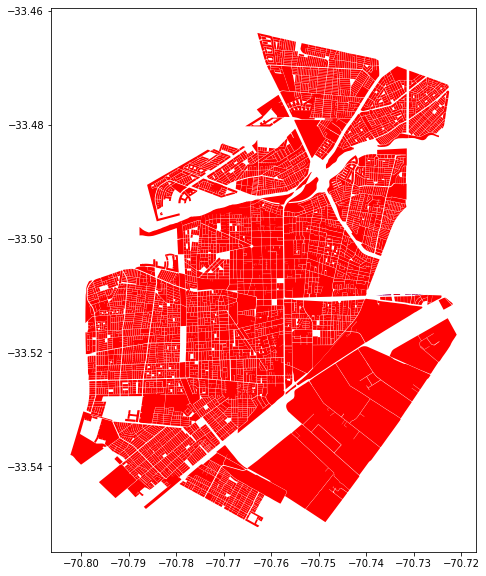

In [9]:
# obtener una lista de todos los ID_MANZENT de ismt_maipu_zonas_pob_socioec
id_manzent = ismt_maipu_zonas_pob_socioec['ID_MANZENT'].tolist()
# obtener una lista de todos los ID_MANZENT de maipu_pob_socioec
id_manzent2 = maipu_pob_socioec['ID_MANZENT'].tolist()
# Hacer la diferencia entre las dos listas
id_manzent3 = list(set(id_manzent2) - set(id_manzent))
# Filtrar maipu_pob_socioec por id_manzent3
maipu_pob_socioec_1 = maipu_pob_socioec[maipu_pob_socioec['ID_MANZENT'].isin(id_manzent3)].reset_index(drop=True)
# Graficar maipu_pob_socioec_1 y maipu_pob_socioec en una mismo plot juntos para ver en donde no se intersectan, con diferentes colores para cada uno
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
maipu_pob_socioec_1.plot(ax=ax, color='blue')
maipu_pob_socioec.plot(ax=ax, color='red')

In [10]:
ismt_maipu_zonas_pob_socioec.columns

Index(['MANZENT_I', 'puntaje_es', 'EDUC', 'puntaje_au', 'Hacin', 'Hacinpunt',
       'NSE', 'GSE_final', 'quintil', 'ID_MANZENT', 'EDAD_65YMA', 'INMIGRANTE',
       'PUEBLO', 'MUJERES', 'HOMBRES', 'EDAD_0A5', 'EDAD_15A64', 'EDAD_6A14',
       'PERSONAS', 'TOTAL_VIV', 'index_righ', 'NOMBRE', 'TIPO_AREA',
       'SHAPE_Leng', 'SHAPE_Area', 'geometry', 'index_right', 'NOM_COMUNA',
       'LOC_ZON', 'prom_ismt', 'AVE_GSE'],
      dtype='object')

In [11]:
for f in ['EDAD_65YMA','INMIGRANTE','PUEBLO','MUJERES','HOMBRES','EDAD_0A5','EDAD_15A64','EDAD_6A14','PERSONAS','TOTAL_VIV']:
    ismt_maipu_zonas_pob_socioec[f]=ismt_maipu_zonas_pob_socioec[f].replace('*',0)
    ismt_maipu_zonas_pob_socioec[f]=ismt_maipu_zonas_pob_socioec[f].astype('float')
    
ismt_maipu_zonas_pob_socioec=ismt_maipu_zonas_pob_socioec[ismt_maipu_zonas_pob_socioec['PERSONAS']>0].reset_index(drop=True)

In [12]:
ismt_maipu_zonas_pob_socioec['densidad']=ismt_maipu_zonas_pob_socioec['PERSONAS']/ismt_maipu_zonas_pob_socioec.geometry.area #personas por m2
ismt_maipu_zonas_pob_socioec['pct_aMayor']=ismt_maipu_zonas_pob_socioec['EDAD_65YMA']/ismt_maipu_zonas_pob_socioec['PERSONAS']*100
ismt_maipu_zonas_pob_socioec['pct_inm']=ismt_maipu_zonas_pob_socioec['INMIGRANTE']/ismt_maipu_zonas_pob_socioec['PERSONAS']*100
ismt_maipu_zonas_pob_socioec['pct_orig']=ismt_maipu_zonas_pob_socioec['PUEBLO']/ismt_maipu_zonas_pob_socioec['PERSONAS']*100
ismt_maipu_zonas_pob_socioec['pct_nna']=(ismt_maipu_zonas_pob_socioec['EDAD_0A5']+ismt_maipu_zonas_pob_socioec['EDAD_6A14'])/ismt_maipu_zonas_pob_socioec['PERSONAS']*100
ismt_maipu_zonas_pob_socioec['pct_adult']=(ismt_maipu_zonas_pob_socioec['EDAD_15A64'])/ismt_maipu_zonas_pob_socioec['PERSONAS']*100
ismt_maipu_zonas_pob_socioec['pct_mujeres']=(ismt_maipu_zonas_pob_socioec['MUJERES'])/ismt_maipu_zonas_pob_socioec['PERSONAS']*100
ismt_maipu_zonas_pob_socioec['pct_hombres']=(ismt_maipu_zonas_pob_socioec['HOMBRES'])/ismt_maipu_zonas_pob_socioec['PERSONAS']*100
ismt_maipu_zonas_pob_socioec.head(1)

C:\Users\chile\AppData\Local\Temp\ipykernel_13208\2893755663.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ismt_maipu_zonas_pob_socioec['densidad']=ismt_maipu_zonas_pob_socioec['PERSONAS']/ismt_maipu_zonas_pob_socioec.geometry.area #personas por m2


,MANZENT_I,puntaje_es,EDUC,puntaje_au,Hacin,Hacinpunt,NSE,GSE_final,quintil,ID_MANZENT,...,prom_ismt,AVE_GSE,densidad,pct_aMayor,pct_inm,pct_orig,pct_nna,pct_adult,pct_mujeres,pct_hombres
0,13119201006001,418.861076,11.64831,0,1.182342,120,538.861076,C3,Q2,13119201006001,...,0.835958,C3,2.108087e+08,5.874587,2.574257,6.336634,19.933993,74.191419,51.287129,48.712871


In [13]:
# Reordenar columnas y solo quedarme coin otdas aquellas que me interesan para el analisis
ismt_maipu_zonas_pob_socioec = ismt_maipu_zonas_pob_socioec[['NOM_COMUNA', 'ID_MANZENT', 'prom_ismt', 'NSE', 'GSE_final', 'TOTAL_VIV', 'densidad', 'pct_aMayor', 'pct_inm', 'pct_orig', 'pct_nna', 'pct_adult', 'pct_mujeres', 'pct_hombres', 'geometry']]


In [14]:
# Normalizar NSE, TOTAL_VIV, pct_aMayor, pct_inm, pct_orig, pct_nna, pct_adult, pct_mujeres, pct_hombres, utilizando la media y la desviacion estandar
ismt_maipu_zonas_pob_socioec['NSE'] = (ismt_maipu_zonas_pob_socioec['NSE'] - ismt_maipu_zonas_pob_socioec['NSE'].mean()) / ismt_maipu_zonas_pob_socioec['NSE'].std()
ismt_maipu_zonas_pob_socioec['TOTAL_VIV'] = (ismt_maipu_zonas_pob_socioec['TOTAL_VIV'] - ismt_maipu_zonas_pob_socioec['TOTAL_VIV'].mean()) / ismt_maipu_zonas_pob_socioec['TOTAL_VIV'].std()
ismt_maipu_zonas_pob_socioec['pct_aMayor'] = (ismt_maipu_zonas_pob_socioec['pct_aMayor'] - ismt_maipu_zonas_pob_socioec['pct_aMayor'].mean()) / ismt_maipu_zonas_pob_socioec['pct_aMayor'].std()
ismt_maipu_zonas_pob_socioec['pct_inm'] = (ismt_maipu_zonas_pob_socioec['pct_inm'] - ismt_maipu_zonas_pob_socioec['pct_inm'].mean()) / ismt_maipu_zonas_pob_socioec['pct_inm'].std()
ismt_maipu_zonas_pob_socioec['pct_orig'] = (ismt_maipu_zonas_pob_socioec['pct_orig'] - ismt_maipu_zonas_pob_socioec['pct_orig'].mean()) / ismt_maipu_zonas_pob_socioec['pct_orig'].std()
ismt_maipu_zonas_pob_socioec['pct_nna'] = (ismt_maipu_zonas_pob_socioec['pct_nna'] - ismt_maipu_zonas_pob_socioec['pct_nna'].mean()) / ismt_maipu_zonas_pob_socioec['pct_nna'].std()
ismt_maipu_zonas_pob_socioec['pct_adult'] = (ismt_maipu_zonas_pob_socioec['pct_adult'] - ismt_maipu_zonas_pob_socioec['pct_adult'].mean()) / ismt_maipu_zonas_pob_socioec['pct_adult'].std()
ismt_maipu_zonas_pob_socioec['pct_mujeres'] = (ismt_maipu_zonas_pob_socioec['pct_mujeres'] - ismt_maipu_zonas_pob_socioec['pct_mujeres'].mean()) / ismt_maipu_zonas_pob_socioec['pct_mujeres'].std()
ismt_maipu_zonas_pob_socioec['pct_hombres'] = (ismt_maipu_zonas_pob_socioec['pct_hombres'] - ismt_maipu_zonas_pob_socioec['pct_hombres'].mean()) / ismt_maipu_zonas_pob_socioec['pct_hombres'].std()
ismt_maipu_zonas_pob_socioec.head(1)


,NOM_COMUNA,ID_MANZENT,prom_ismt,NSE,GSE_final,TOTAL_VIV,densidad,pct_aMayor,pct_inm,pct_orig,pct_nna,pct_adult,pct_mujeres,pct_hombres,geometry
0,MAIPÚ,13119201006001,0.835958,0.074715,C3,9.940017,2.108087e+08,-0.489394,0.287186,-0.375529,0.791415,0.338051,-0.126608,0.157637,"POLYGON ((-70.76015 -33.46445, -70.76006 -33.4..."


<AxesSubplot:>

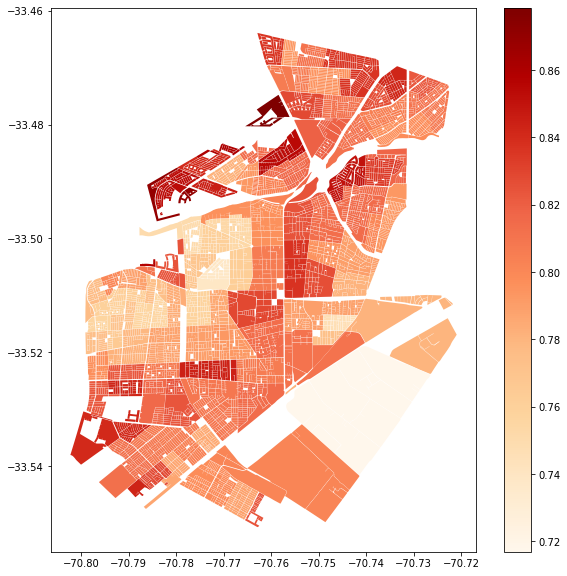

In [16]:
ismt_maipu_zonas_pob_socioec.plot(column='prom_ismt', cmap='OrRd', legend=True, figsize=(10,10))

In [17]:
# Pasar a GeoJson ismt_maipu_zonas_pob_socioec para poder ocupar geemap
import json 
maipu_ind_json = ismt_maipu_zonas_pob_socioec.to_json()
maipu_ind_json = json.loads(maipu_ind_json)

# Pasar a GeoJson maipu para poder ocupar geemap
maipu_json = maipu.to_json()
maipu_json = json.loads(maipu_json)

In [18]:
import geemap
import ee

# Iniciar flujo de autentificación 
#ee.Authenticate()
 
# Inicializar la librería.
ee.Initialize()

In [19]:
# Crear una lista para almacenar los polígonos individuales
polygons = []

# Iterar sobre las características en maipu_ind_json
for feature in maipu_ind_json['features']:
    coordinates = feature['geometry']['coordinates'][0]  # Obtener las coordenadas del primer polígono
    polygon = ee.Geometry.Polygon(coordinates)
    polygons.append(polygon)

# Unir todos los polígonos en uno solo
maipu_ind_geometry = ee.Geometry.MultiPolygon(polygons).dissolve()

# Graficar el polígono de maipu_ind_geometry
Map = geemap.Map()
Map.centerObject(maipu_ind_geometry, 12)
Map.addLayer(maipu_ind_geometry, {}, 'maipu_ind_geometry')
Map

Map(center=[-33.511431519987894, -70.75981695834673], controls=(WidgetControl(options=['position', 'transparen…

In [20]:
maipu_geometry = ee.Geometry.Polygon(maipu_json['features'][0]['geometry']['coordinates'])
# Graficar el polígono de maipu_ind_geometry
Map = geemap.Map()
Map.centerObject(maipu_geometry, 12)
Map.addLayer(maipu_geometry, {}, 'maipu_geometry')
Map

Map(center=[-33.50702954289921, -70.80961369751469], controls=(WidgetControl(options=['position', 'transparent…

In [21]:
# Crear tuplas de todos los meses de enero desde el 2019 hasta el 2022
fechas = [('2019-01-01', '2019-12-31', '2019'), ('2020-01-01', '2020-12-31', '2020'), 
          ('2021-01-01', '2021-12-31', '2021'), ('2022-01-01', '2022-12-31', '2022')]

In [22]:
# Agregar a un diccionario las imagenes de Sentinel 2 de cada mes de enero desde el 2019 hasta el 2022
dict_image_maipu = {}
for i in fechas:
    if i[2] == '2022':
        # Para el 2022 se obtiene la cuarta imagen con menor porcentaje de nubosidad
        image = ee.ImageCollection('COPERNICUS/S2')\
            .filterDate(i[0], i[1])\
            .filterBounds(maipu_geometry)\
            .sort('CLOUDY_PIXEL_PERCENTAGE', True)\
            .toList(4, 0)\
            .get(3)
        image = ee.Image(image).clip(maipu_geometry)
        dict_image_maipu[i[-1]] = image
    else:
        image = ee.ImageCollection('COPERNICUS/S2')\
            .filterDate(i[0], i[1])\
            .filterBounds(maipu_geometry)\
            .sort('CLOUDY_PIXEL_PERCENTAGE', True)\
            .first()\
            .clip(maipu_geometry)
        dict_image_maipu[i[-1]] = image

In [62]:
# hacer Map de dict_image_maipu
Map = geemap.Map()
Map.centerObject(maipu_geometry, 12)
Map.addLayer(dict_image_maipu['2019'], {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, '2019')
Map.addLayer(dict_image_maipu['2020'], {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, '2020')
Map.addLayer(dict_image_maipu['2021'], {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, '2021')
Map.addLayer(dict_image_maipu['2022'], {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, '2022')
Map


Map(center=[-33.50702954289921, -70.80961369751469], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
import requests
import geopandas as gpd
from shapely.geometry import shape

# Define la URL de la consulta
url = "https://sitmaipu.cl/arcgis/rest/services/Servicios/PRC_Zonificacion/MapServer/1/query"

# Define los parámetros de la consulta
params = {
    "f": "geoJSON",
    "where": "ZONA='ZC1' OR ZONA='ZC2' OR ZONA='ZC3' OR ZONA='ZC4' OR  ZONA='ZH1' OR ZONA='ZH2' OR ZONA='ZH3' OR ZONA='ZH4' OR ZONA='ZH5' OR ZONA='ZH6' OR ZONA='ZH7' OR ZONA='ZH8' OR ZONA='ZH9' OR ZONA='ZH10'",
    "outFields": "*",
    "returnGeometry": "true"
}

# Realiza la consulta
response = requests.get(url, params=params)

# Comprueba que la consulta fue exitosa
response.raise_for_status()

# Convierte la respuesta a JSON
data = response.json()

# Extrae las características (features) de la respuesta
features = data["features"]

# Filtra las características que tienen una geometría
features_with_geometry = [f for f in features if f["geometry"] is not None]

In [ ]:
# crear un GeoDataFrame con los polígonos y guardando la descripción de cada polígono
zonas_habitacionales_maipu = gpd.GeoDataFrame.from_features(features_with_geometry)


In [ ]:
zonas_habitacionales_maipu.head(1)

,geometry,OBJECTID,ZONA,NOMBRE,CARACTERISTICAS,CLASIFICACION,DESCRIPCION,ORDENANZA,MODIFICACION,OBSERVACIONES,OWNER,FECHA_CREACION,EDITOR,FECHA_EDICION,ORDENANZA_TXT,Shape.STLength()
0,"POLYGON ((-70.72604 -33.47599, -70.72595 -33.4...",1924,ZH6,,,Zonas de Uso preferente vivienda con equipamiento,Zona Habitacional 6: MaipÃº Norte - Sector Vil...,\\VSITMABD\PRC_ZONA\ZH6.pdf,None,None,SDE,1503273600000,AU,1503273600000,None,3912.849483


<AxesSubplot:>

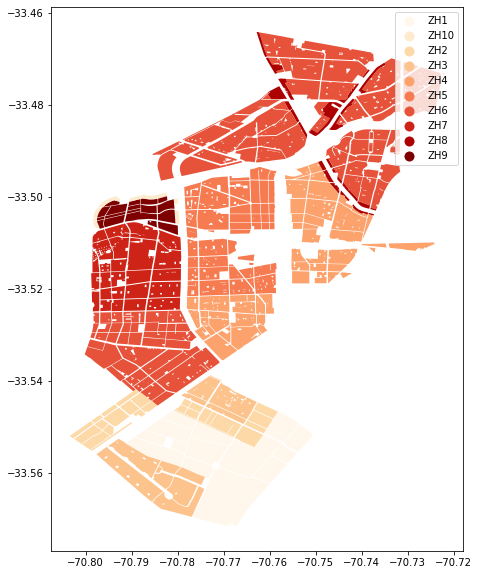

In [ ]:
# Visualizar el GeoDataFrame que son las zonas habitacionales de Maipú
zonas_habitacionales_maipu.plot(column='ZONA', cmap='OrRd', legend=True, figsize=(10,10))

In [ ]:
# Crear una lista para almacenar los polígonos individuales
polygons = []

# Iterar sobre features_with_geometry
for feature in features_with_geometry:
    coordinates = feature['geometry']['coordinates'][0]  # Obtener las coordenadas del primer polígono
    polygon = ee.Geometry.Polygon(coordinates)
    polygons.append(polygon)

# Unir todos los polígonos en uno solo
zonas_habitacionales_maipu_geometry = ee.Geometry.MultiPolygon(polygons).dissolve()


In [ ]:
# Graficar el polígono de maipu_ind_geometry
Map = geemap.Map()
Map.centerObject(zonas_habitacionales_maipu_geometry, 12)
Map.addLayer(zonas_habitacionales_maipu_geometry, {}, 'zonas_habitacionales_maipu_geometry')
Map

Map(center=[-33.51750941062017, -70.76752551630307], controls=(WidgetControl(options=['position', 'transparent…